# bcal neutron imagery
This notebook reads the output of the physics simulation of the GlueX detector in response to single high-energy neutrons come from the liquid hydrogen target. Neutrons are fired from the photon beam - target overlap region that lies close to the long axis of the hydrogen target at its nominal position in the GlueX spectrometer. The neutrons are distributed uniformly in energy and angle over the range from 0 to 1 GeV kinetic energy, between lab polar angles 0 and 160 degrees from the beam axis, and over the full range 0 - 360 degrees in azimuth. The images display the ionization energy deposited in the barrel electromagnetic calorimeter (BCAL) projected onto the xy plane, as a color-coded heat map. The deposited energy is the integral over all times for a given primary neutron event. To make the images more compact, only the BCAL module that was directly along the flight path of the neutron and its two neighbors on either side are included in the images. The third dimension of the hit position along the length of the modules is not encoded in the images.


## Define the module geometry
The BCAL consists of a complete cylinder divided equally along its azimuth in identical module. Each module is further divided into radial rings called layers, and each layer is subdivided along its azimuth into sectors. The table Rsectors gives the inner radius of each layer in sectors. All of the other dimensions are determined by the geometry, assuming no gaps between neighboring sectors and layers.

In [1]:
Nmodules = 48
Nsectors = [4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Rsectors = [65.0423, 67.10986, 69.17742, 71.24498,
            73.31254, 75.3801, 77.44766, 79.92162,
            82.39558, 84.86954, 87.3435]

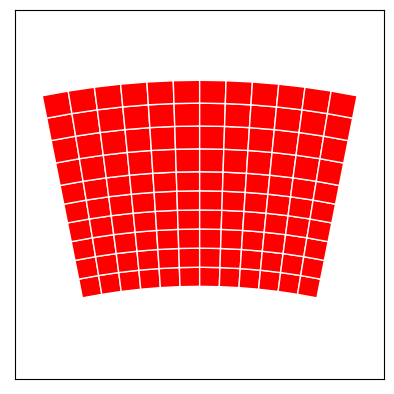

In [2]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.transforms as mtransforms
#matplotlib.use("Agg")

fig,ax = plt.subplots()

sectors = {}
corners = {}

for layer in range(len(Nsectors)):
    for module in range(-1,2):
        phi = (module - 0.5) * 2*math.pi/Nmodules
        for sector in range(Nsectors[layer]):
            dphi = 2*math.pi/Nmodules / Nsectors[layer]
            r0 = Rsectors[layer]
            r1 = Rsectors[layer + 1]
            mls = f"{module}:{layer}:{sector}"
            corners[mls] = np.array([[r0 * math.sin(phi), r0 * math.cos(phi)],
                                     [r1 * math.sin(phi), r1 * math.cos(phi)],
                                     [r1 * math.sin(phi + dphi), r1 * math.cos(phi + dphi)],
                                     [r0 * math.sin(phi + dphi), r0 * math.cos(phi + dphi)],
                                     [r0 * math.sin(phi), r0 * math.cos(phi)]])
            sectors[mls] = Polygon(corners[mls], facecolor='r', edgecolor='w')
            ax.add_patch(sectors[mls])
            phi += dphi
ax.set_xlim([-20,20])
ax.set_ylim([55,95])
ax.set_aspect("equal")
plt.xticks([])
plt.yticks([])
plt.show()

## Choose a color map
To display deposited energy as a hue, we need to choose a color map. Below we experiment with different color maps to see what looks best.

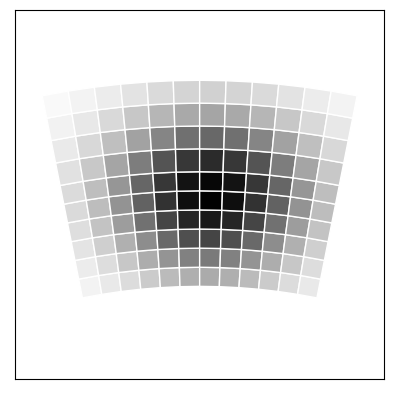

In [3]:
#colormap = matplotlib.cm.get_cmap('YlOrRd')
colormap = matplotlib.cm.get_cmap('binary')
rmax = 75
phimax = 0
rsigma = 6
phisigma = 0.1

fig,ax = plt.subplots()
heatmap = {}

for mls in corners:
    module, layer, sector = [int(index) for index in mls.split(':')]
    phi = (module + sector/Nsectors[layer] - 0.5) * 2*math.pi/Nmodules
    energy = math.exp(-0.5 * (((Rsectors[layer]/2 + Rsectors[layer + 1]/2 - rmax) / rsigma)**2 +
                              ((phi - phimax) / phisigma)**2))
    heatmap[mls] = Polygon(corners[mls], edgecolor='w', facecolor=colormap(energy))
    ax.add_patch(heatmap[mls])
ax.set_xlim([-20,20])
ax.set_ylim([55,95])
ax.set_aspect("equal")
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
import sys
sys.path.append("/cvmfs/oasis.opensciencegrid.org/gluex/halld_recon/Linux_CentOS7-x86_64-gcc6.3.1/python3")
import hddm_s

#!{sys.executable} -m pip install --user wget
import wget
import os

In [5]:
neutrons = "http://nod25.phys.uconn.edu:2880/Gluex/simulation/simsamples/particle_gun" +\
           "/particle_gun021_{0:03d}.hddm"
module_dphi = 2*math.pi / Nmodules
module_phi0 = -2*math.pi + module_dphi/2

logEmin_GeV = math.log(0.001)
logEmax_GeV = math.log(1.000)
mNeutron = 0.939565346

showedges = False
production = False

def Escaled(E_GeV):
    """
    Return a value representing the energy deposited by a neutron
    in a BCAL sector, on a scale (0,1).
    """
    return (math.log(E_GeV) - logEmin_GeV) / (logEmax_GeV - logEmin_GeV) 

for n in range(5):
    try:
        url = neutrons.format(n+1)
        hddmfile = wget.download(url)
        nevents = 0
        for evt in hddm_s.istream(hddmfile):
            sectors = [{}, {}]
            for pe in evt.getPhysicsEvents():
                nevents += 1
                for mom in evt.getMomenta():
                    pperp = (mom.px**2 + mom.py**2)**0.5
                    labtheta = math.atan2(pperp, mom.pz)
                    if labtheta < 15 * math.pi/180:
                        continue
                    labphi = math.atan2(mom.py, mom.px)
                    module0 = int((labphi - module_phi0) / module_dphi) % Nmodules + 2
                    Ekin = mom.E - mNeutron
                    momrec = str(mom)
                for cell in evt.getBcalCells():
                    if abs(cell.module - module0) > 1 and abs(cell.module - module0) < Nmodules - 1:
                        continue
                    dmod = (cell.module - module0 + Nmodules + 5) % Nmodules - 5
                    mls = f"{dmod}:{cell.layer - 1}:{cell.sector - 1}"
                    for hit in cell.getBcalSiPMUpHits():
                        sectors[0][mls] = Polygon(corners[mls], edgecolor='w',
                                                  facecolor=colormap(Escaled(hit.E)))
                    for hit in cell.getBcalSiPMDownHits():
                        sectors[1][mls] = Polygon(corners[mls], edgecolor='w',
                                                  facecolor=colormap(Escaled(hit.E)))
            if len(sectors[0]) > 0 or len(sectors[1]) > 0:
                fig,ax = plt.subplots(ncols=2, constrained_layout=True)
                if showedges:
                    for mls in corners:
                        p0 = Polygon(corners[mls], edgecolor='tan', facecolor='w')
                        p1 = Polygon(corners[mls], edgecolor='tan', facecolor='w')
                        ax[0].add_patch(p0)
                        ax[1].add_patch(p1)
                for mls in sectors[0]:
                    ax[0].add_patch(sectors[0][mls])
                for mls in sectors[1]:
                    ax[1].add_patch(sectors[1][mls])
                for end in (0,1):
                    ax[end].set_xlim([-20,20])
                    ax[end].set_ylim([55,95])
                    ax[end].set_aspect("equal")
                    ax[end].set_xticks([])
                    ax[end].set_yticks([])
                meta = {"event_kinematics": momrec}
                plt.savefig(f"GANsim/images/f{n}e{pe.eventNo}u.png", dpi=45, metadata=meta,
                            bbox_inches=mtransforms.Bbox([[0.03,0.2],[0.48,0.8]]).transformed(
                                (fig.transFigure - fig.dpi_scale_trans)))
                plt.savefig(f"GANsim/images/f{n}e{pe.eventNo}d.png", dpi=45, metadata=meta,
                            bbox_inches=mtransforms.Bbox([[0.53,0.2],[0.98,0.8]]).transformed(
                                (fig.transFigure - fig.dpi_scale_trans)))
                plt.savefig(f"GANsim/images/f{n}e{pe.eventNo}.png", dpi=45, metadata=meta,
                            bbox_inches=mtransforms.Bbox([[0.0,0.15],[1.0,0.85]]).transformed(
                                (fig.transFigure - fig.dpi_scale_trans)))
                if pe.eventNo < 25:
                    print(f"display event", pe.runNo, pe.eventNo,
                          f"with neutron kinetic energy {Ekin:.3f} GeV")
                    plt.show()
                else:
                    plt.close(fig)
            else:
                if pe.eventNo < 25:
                    print(f"event", pe.runNo, pe.eventNo, "has no bcal hits")
            if not production and pe.eventNo >= 25:
                raise Exception("done with this input file")
            elif production and pe.eventNo == 25:
                print(f"continuing with silent production of images for run {pe.runNo}")
    except:
        if not production:
            print(f"early exit after {nevents} events from input file {hddmfile}")
        else:
            raise
    finally:
        if os.path.isfile(hddmfile):
            os.remove(hddmfile)

NameError: name 'hddmfile' is not defined